<a href="https://colab.research.google.com/github/Aveturi13/cmri_planning/blob/master/notebooks/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automating Cardiac MRI Planning using Deep Learning: Part I**





**Introduction to Cardiac MRI**

Cardiac MRI is a highly advanced imaging modality that is used for evaluating complex congenital and acquired heart conditions like cardiomyopathies, ischemic heart disease, valvular defects and pericardial defects. In a typical CMR protocol, the patient is placed into a 1.5-3.0T scanner and a radiographer acquires images of the heart from different views.

<p align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/1/14/Myxoma_CMR.gif" height=360 width=450>
<p align="center">Image taken from Wikimedia Commons.</p> 
</p>


These views are planned by prescribing lines onto the image passing through landmarks like the apex, mitral valve, tricuspid valve etc. This creates a slice through the image, producing the view. In the standard CMR planning procedure, two compulsory views are the 4Ch and 2Ch views. Refering to the above image, in the 4Ch view (top left), all chambers of the heart are visible. In the 2Ch view (top right), only one side of the heart is visible.

**Disadvantages of CMR Planning protocol**

The problems with this protocol, however, is that the process is time-consuming, taking atleast an hour, and requires highly competent radiographers who are capable of operating the MRI machine and have an excellent knowledge of cardiac anatomy. These specialists are not availiable in all centers and also, the process is manual which means there is a high scope for error and inconsistencies, which can impact clinical decisions made by the radiologist. In order to deal with these limitations, this project focuses on automating the planning process using deep learning techniques. As proof of concept, I focus on predicting the 2Ch planning line from a 4Ch cardiac image.

**Approach to planning automation**

I approach the planning process using 2 methods - semantic segmentation and parameter estimation. This notebook focuses on semantic segmentation. 

Semantic segmentation involves classifying the pixels on the image to one of two classes - 'line' and 'background'. To perform this, we create a mask of the same dimensions as the image. For every pixel on the original image, if the pixel belongs to the 'line' class, then the corresponding pixel on the mask stores a value of `1.0` and if 'background', then `0.0`. So to automate the line planning, we aim to design a deep learning model that can read the input image and predict the line mask.

This project is run on Google Colab, a cloud-based Jupyter Notebook service provided by Google that gives access to NVIDIA GPUs. I begin by first importing the data from my drive into the colab.

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Change to project directory
%cd drive/My Drive/ML Projects/cardiac_image_planning/notebooks/

/content/drive/.shortcut-targets-by-id/1EVk3fziF5Q5vsctlMwG3AMvf5Ps62xKp/ML Projects/cardiac_image_planning/notebooks


## 1.0 - Import essential modules and packages



In [ ]:
import os, glob
from random import shuffle
import pandas as pd
import numpy as np
import cv2 as cv
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
import skimage.draw as skdraw

## 2.0 - Data Exploration

The images are stored in the dataset directory. Let's load the filepaths into memory.

In [ ]:
data_path = '../dataset/two_2_four_justdiastole'
glob_search = os.path.join(data_path, '00*.png')
img_dir = sorted(glob.glob(glob_search))
print(img_dir)

['../dataset/two_2_four_justdiastole/00000.png', '../dataset/two_2_four_justdiastole/00001.png', '../dataset/two_2_four_justdiastole/00002.png', '../dataset/two_2_four_justdiastole/00003.png', '../dataset/two_2_four_justdiastole/00004.png', '../dataset/two_2_four_justdiastole/00005.png', '../dataset/two_2_four_justdiastole/00006.png', '../dataset/two_2_four_justdiastole/00007.png', '../dataset/two_2_four_justdiastole/00008.png', '../dataset/two_2_four_justdiastole/00009.png', '../dataset/two_2_four_justdiastole/00010.png', '../dataset/two_2_four_justdiastole/00011.png', '../dataset/two_2_four_justdiastole/00012.png', '../dataset/two_2_four_justdiastole/00013.png', '../dataset/two_2_four_justdiastole/00014.png', '../dataset/two_2_four_justdiastole/00015.png', '../dataset/two_2_four_justdiastole/00016.png', '../dataset/two_2_four_justdiastole/00017.png', '../dataset/two_2_four_justdiastole/00018.png', '../dataset/two_2_four_justdiastole/00019.png', '../dataset/two_2_four_justdiastole/000

The 2Ch planning lines for these 4Ch images are numerically represented by a coordinate $(x, y)$ and the slope of the line $dy/dx$. These values are stored in the csv file `'two_2_four_diastole.csv'`. Let's load these values.

In [ ]:
#Read the csv file
df = pd.read_csv('../dataset/fourc_pred_twoc.csv', header=None)

#Ignoring the index column
line_data = df.iloc[:, 1:]
print(line_data.head())

            1           2          3           4
0   88.656968   91.981815  77.949571  124.721745
1  162.645745  102.514604 -66.311019   95.066142
2  111.146288  178.712147  92.911195  -82.967343
3  179.808242   97.404423 -75.815464  100.255553
4  132.123605  183.549039  77.485904  -73.764198


The rows are the values for each image. The columns correspond to `x`, `y`, `dx`, `dy` respectively. For doing operations on the data, the values are taken from the dataframe and represented as a matrix.

In [ ]:
#Convert dataframe into a matrix
line_array = line_data.values
print(line_array)

[[  88.65696831   91.98181467   77.9495713   124.72174514]
 [ 162.64574542  102.51460421  -66.31101878   95.06614183]
 [ 111.14628822  178.71214674   92.91119516  -82.96734256]
 ...
 [ 146.24318483  180.16648959   76.79185583 -105.54602682]
 [ 169.30201596  224.44887293  -40.51991469  -98.92945292]
 [ 127.65932817  197.00170223   88.91035973 -112.78561316]]


A few images are inspected below. To construct the 2Ch planning line on the image, I use the equation y = mx + b where m is the slope and b is the intercept calculated using the values in `'two_2_four_diastole.csv'`.

Number of Patients: 607 patients.



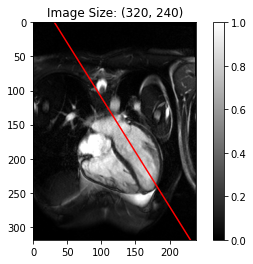

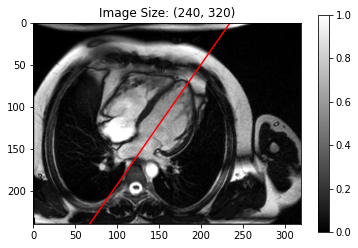

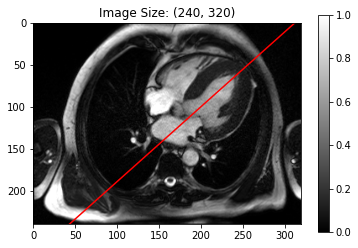

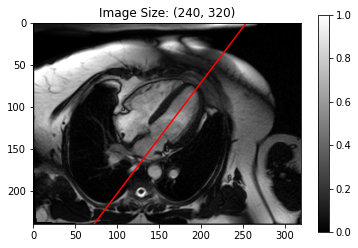

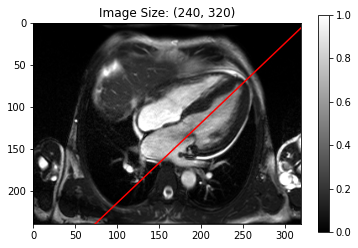

In [ ]:
print('Number of Patients: {} patients.\n'.format(line_array.shape[0]))

for i in range(5):
  plt.figure()
  img = plt.imread(img_dir[i])
  plt.imshow(img, plt.cm.gray)

  m = line_array[i, 3] / line_array[i, 2] 
  b = line_array[i, 1] - m * line_array[i, 0]

  x = np.arange(0, img.shape[1])
  y = m*x + b 
  plt.plot(x, y, 'red')

  plt.xlim(0, img.shape[1]-1)
  plt.ylim(img.shape[0]-1, 0)
  plt.title('Image Size: {}'.format(img.shape))
  plt.colorbar()

## 3.0 - Data Preprocessing

From the image dataset exploration, it can be seen that the images are of different sizes. Also, for performing semantic segmentation, the line values need to be converted into a mask that can be superimposed on the image. This is done using a preprocessing function has been implemented below. Preprocessing will take a few minutes.

In [ ]:
from helper_functions import semseg

In [ ]:
#images and masks will be arrays of shape (dataset size, 160, 160, 1)
images, masks, cache = semseg.load_data(img_dir, line_array)

The images and target masks are visualized below.

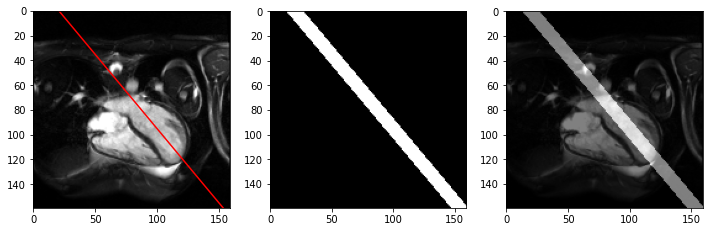

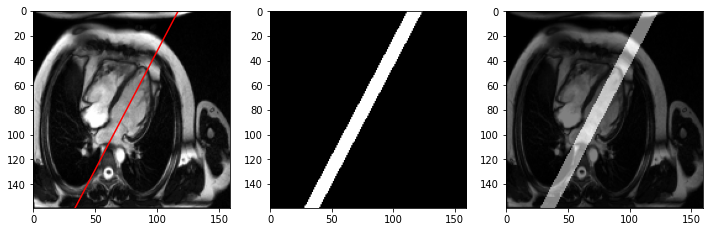

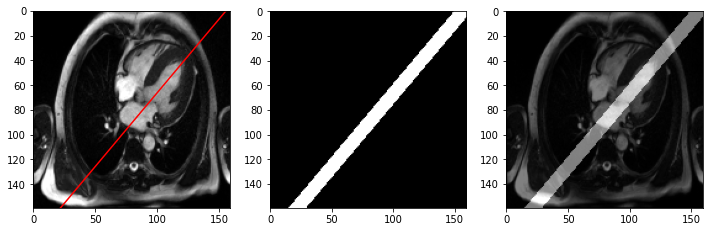

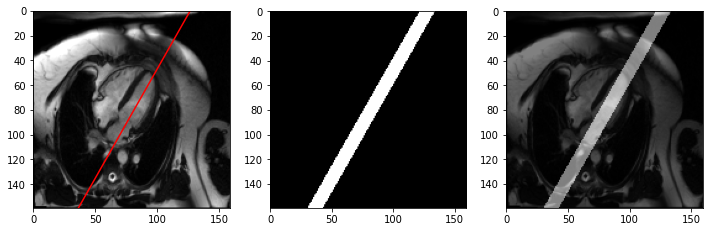

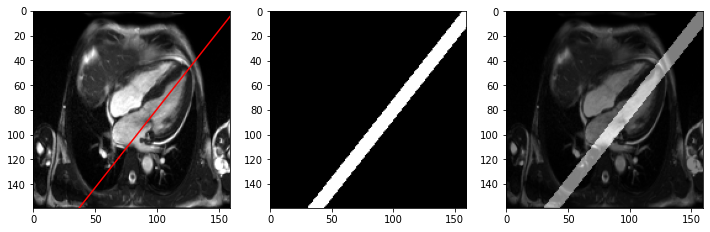

In [ ]:
N=5
m_values, b_values = cache[:, 0], cache[:, 1]

for i in range(N):
  plt.figure(figsize=(12, 12))
  img = images[i].squeeze() 
  msk = masks[i].squeeze()

  plt.subplot(1, 3, 1)
  x = np.arange(0, 160)
  y = m_values[i]*x + b_values[i]
  plt.plot(x, y, 'red')
  plt.imshow(img, plt.cm.gray)
  plt.xlim(0, 159)
  plt.ylim(159, 0)

  plt.subplot(1, 3, 2)
  plt.imshow(msk, plt.cm.gray)

  plt.subplot(1, 3, 3)
  plt.imshow(img, plt.cm.gray)
  plt.imshow(msk, plt.cm.gray, alpha=0.5)

## 4.0 - Image and Mask Generator

The images and targets are passed to the deep learning model using a generator function. First, the data must be divided into training and validation sets.

In [ ]:
np.random.seed(1)

#Shuffle data
state = np.random.get_state()
images_shuffled = np.random.permutation(images)

np.random.set_state(state)
masks_shuffled = np.random.permutation(masks)

np.random.set_state(state)
cache_shuffled = np.random.permutation(cache)

In [ ]:
#Setup train and val sets
split_index = int(0.80 * images_shuffled.shape[0])

train_images = images_shuffled[:split_index] 
train_masks = masks_shuffled[:split_index]

val_images = images_shuffled[split_index:]
val_masks = masks_shuffled[split_index:]

#Create separate cache for later use in the evaluation section
train_cache = cache_shuffled[:split_index]
val_cache = cache_shuffled[split_index:]

As the dataset is limited, data transforms are applied to ensure the model is able to generalize to different cases. 

In [ ]:
data_gen_args = dict(rotation_range=10,
                     width_shift_range=15,
                     height_shift_range=15,
                     zoom_range=[0.9, 1.2],
                     vertical_flip=True,
                     fill_mode='constant',
                     cval=0)

idg = ImageDataGenerator(**data_gen_args)

In [ ]:
def generator(images, masks, batch_size=128, seed=1):
  while True:
    image_generator = idg.flow(images, batch_size=batch_size, shuffle=True, seed=1)
    mask_generator = idg.flow(masks, batch_size=batch_size, shuffle=True, seed=1)

    batch_x = next(image_generator)
    batch_y = next(mask_generator)

    yield(batch_x, batch_y)

In [ ]:
#Create training and validation set generators
train_generator = generator(images=train_images, masks=train_masks, batch_size=128)
validation_data = (val_images, val_masks)

In [ ]:
np.random.seed(1)
X, Y = next(train_generator)

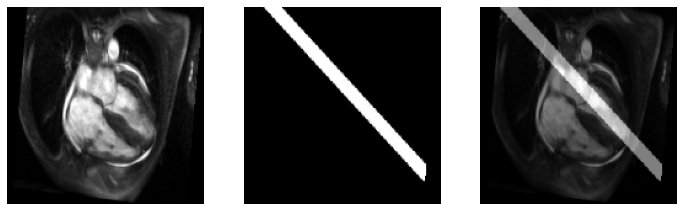

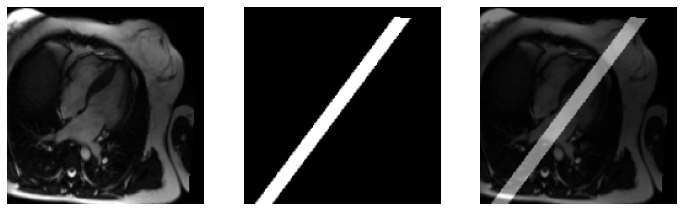

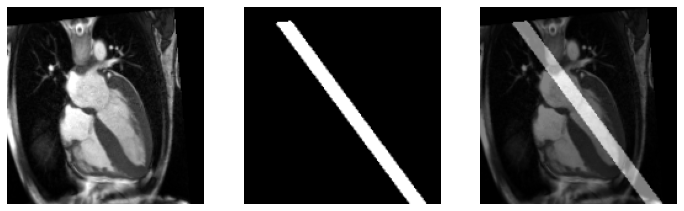

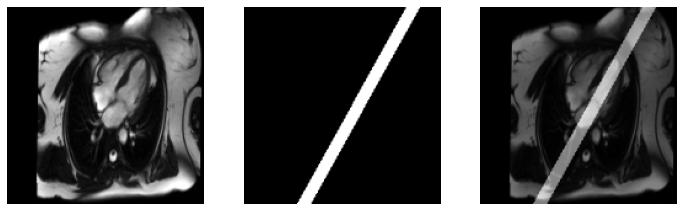

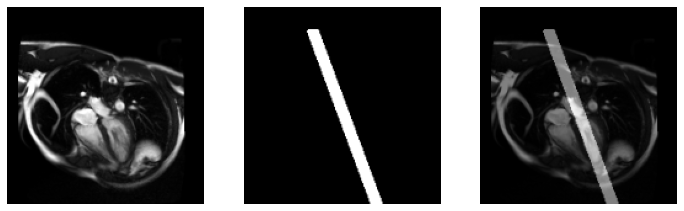

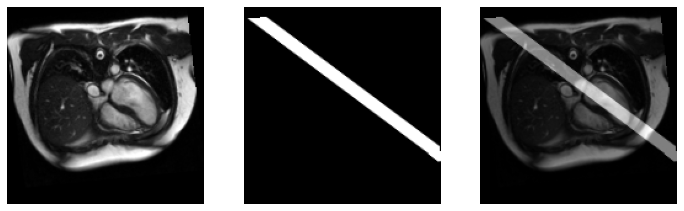

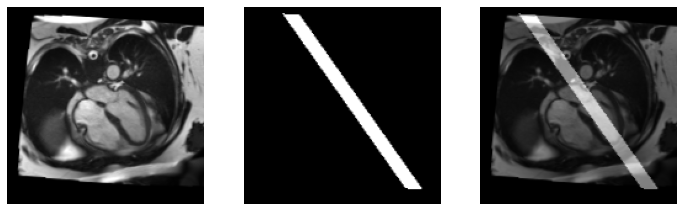

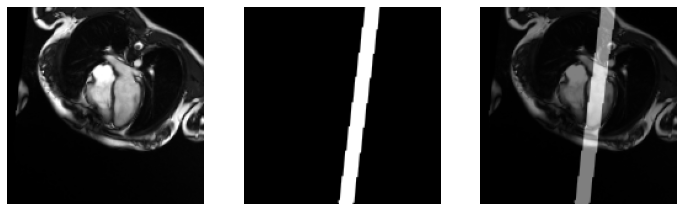

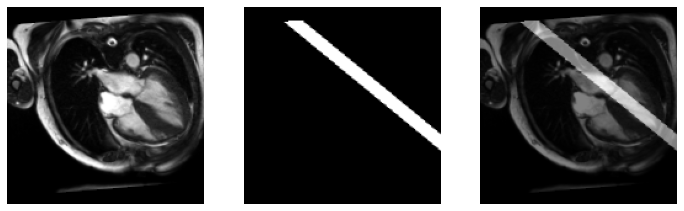

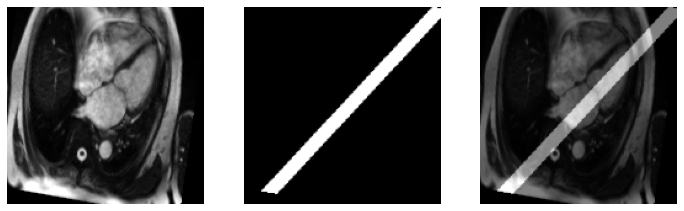

In [ ]:
for i in range(10):
  plt.figure(figsize=(12, 12))
  img = X[i].squeeze() 
  msk = Y[i].squeeze()

  plt.subplot(1, 3, 1)
  plt.axis('off')
  plt.imshow(img, plt.cm.gray)

  plt.subplot(1, 3, 2)
  plt.axis('off')
  plt.imshow(msk, plt.cm.gray)

  plt.subplot(1, 3, 3)
  plt.axis('off')
  plt.imshow(img, plt.cm.gray)
  plt.imshow(msk, plt.cm.gray, alpha=0.5)

## 5.0 - Preparing Deep Learning Model

The deep learning model that will be used to predict the planning line is the UNet. The original paper describing this architecture is described in this [paper](https://https://arxiv.org/abs/1505.04597). For this project, I have slightly modified the architecture to deal with my images, which is shown below.

Let's import the UNet model.

In [ ]:
from networks import unet
import keras
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K

To measure accuracy of the model, the DICE score is also used which calculates the overlap between the true and predicted masks. This score is in the range of $[0,1]$ where 1 is perfect overlap and 0 is no overlap.





<p align="center">
<img src="https://ilmonteux.github.io/assets/images/segmentation/metrics_iou_dice.png">
</p>
<p align="center">
Image Taken from <a href="https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html">this</a> website.
</p>



In [ ]:
def dice_score(y_true, y_pred, axis=None, smooth=1):

  #Convert predicted mask to a one-hot encoding
  y_true = K.round(y_true)
  y_pred = K.round(y_pred)

  #Calculate DICE score
  intersection = K.sum(y_true * y_pred, axis=axis)
  area_true = K.sum(y_true, axis=axis)
  area_pred = K.sum(y_pred, axis=axis)

  return (2 * intersection + smooth)/(area_true + area_pred + smooth)

The model is now compiled. Binary cross entropy loss is used to optimize the model and DICE score measures the accuracy.

In [ ]:
model = unet.unet(batchnorm=True, dropout=0.0, reg=None)
model.compile(optimizer='Adam', loss ='binary_crossentropy', metrics = [dice_score])

The model is summarized below.

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160, 160, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 160, 160, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

### 5.1 - Build Callbacks

Callbacks are important for monitoring the progress of the model training over each epoch.

In [ ]:
def build_callbacks():
  #Instance of ModelCheckpoint class = ModelCheckpoint class saves the model after every epoch.
  checkpointer = ModelCheckpoint(filepath='model.h5', verbose=0, save_best_only=True, save_weights_only=True)
  callbacks = [checkpointer] #[checkpointer, PlotLearning()]
  return callbacks

## 6.0 - Model Training

The below code is to train the model. The model is trained for 30 epochs.

In [ ]:
train_steps= len(train_images)//128
model.fit(x=train_generator,
          epochs=30,
          verbose=1,
          callbacks=build_callbacks(),
          validation_data=validation_data,
          steps_per_epoch=train_steps)

Epoch 1/30
3/3 [==============================] - 5s 2s/step - loss: 0.0142 - dice_score: 0.9844 - val_loss: 0.4363 - val_dice_score: 0.5318
Epoch 2/30
3/3 [==============================] - 5s 2s/step - loss: 0.0141 - dice_score: 0.9844 - val_loss: 0.4322 - val_dice_score: 0.5338
Epoch 3/30
3/3 [==============================] - 5s 2s/step - loss: 0.0141 - dice_score: 0.9845 - val_loss: 0.4295 - val_dice_score: 0.5341
Epoch 4/30
3/3 [==============================] - 5s 2s/step - loss: 0.0141 - dice_score: 0.9841 - val_loss: 0.4250 - val_dice_score: 0.5380
Epoch 5/30
3/3 [==============================] - 4s 1s/step - loss: 0.0150 - dice_score: 0.9799 - val_loss: 0.4375 - val_dice_score: 0.5278
Epoch 6/30
3/3 [==============================] - 4s 1s/step - loss: 0.0155 - dice_score: 0.9765 - val_loss: 0.4406 - val_dice_score: 0.5273
Epoch 7/30
3/3 [==============================] - 4s 1s/step - loss: 0.0169 - dice_score: 0.9698 - val_loss: 0.4475 - val_dice_score: 0.5339
Epoch 8/30
3/

## 7.0 - Model Evaluation

Now the model is evaluated for it's prediction on unseen images. As the dataset is quite small, the validation set images were used as the test images.

### 7.1 - Load a Previous Model

In [ ]:
#Destination of previous file
dest_path = 'segmentation/final_model/'

#Loading pre-existing weights
model.load_weights(dest_path + 'weights.h5')

### 7.2 - Visualize Metrics

The loss and accuracy metrics over each epoch of training are visualized in the below code.

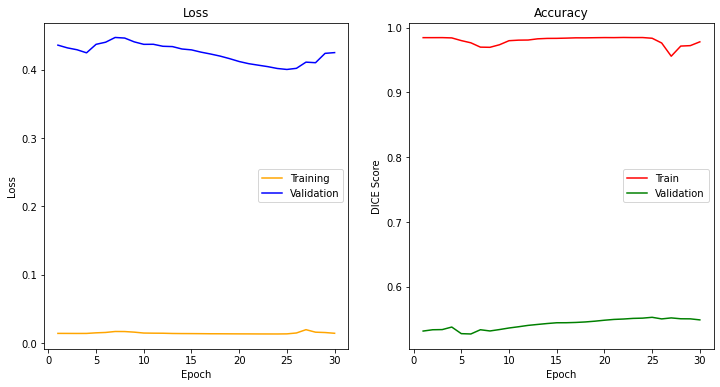

In [ ]:
#Plot evaluation metrics
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
dice_accuracy = model.history.history['dice_score']
val_dice_accuracy = model.history.history['val_dice_score']
epochs = np.arange(1, 31)

#Plot Training and Validation Loss/IoU
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, color='orange')
plt.plot(epochs, val_loss, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, dice_accuracy, color='red')
plt.plot(epochs, val_dice_accuracy, color='green')
plt.xlabel('Epoch')
plt.ylabel('DICE Score')
plt.legend(['Train', 'Validation'])
plt.title('Accuracy')

#Save file to metrics folder
#plt.savefig(dest_path + 'metrics')

plt.show()

### 7.3 - Viewing Test images

The model predicted masks for the test images are visualized below. The ground truth masks are also visualized for comparison.

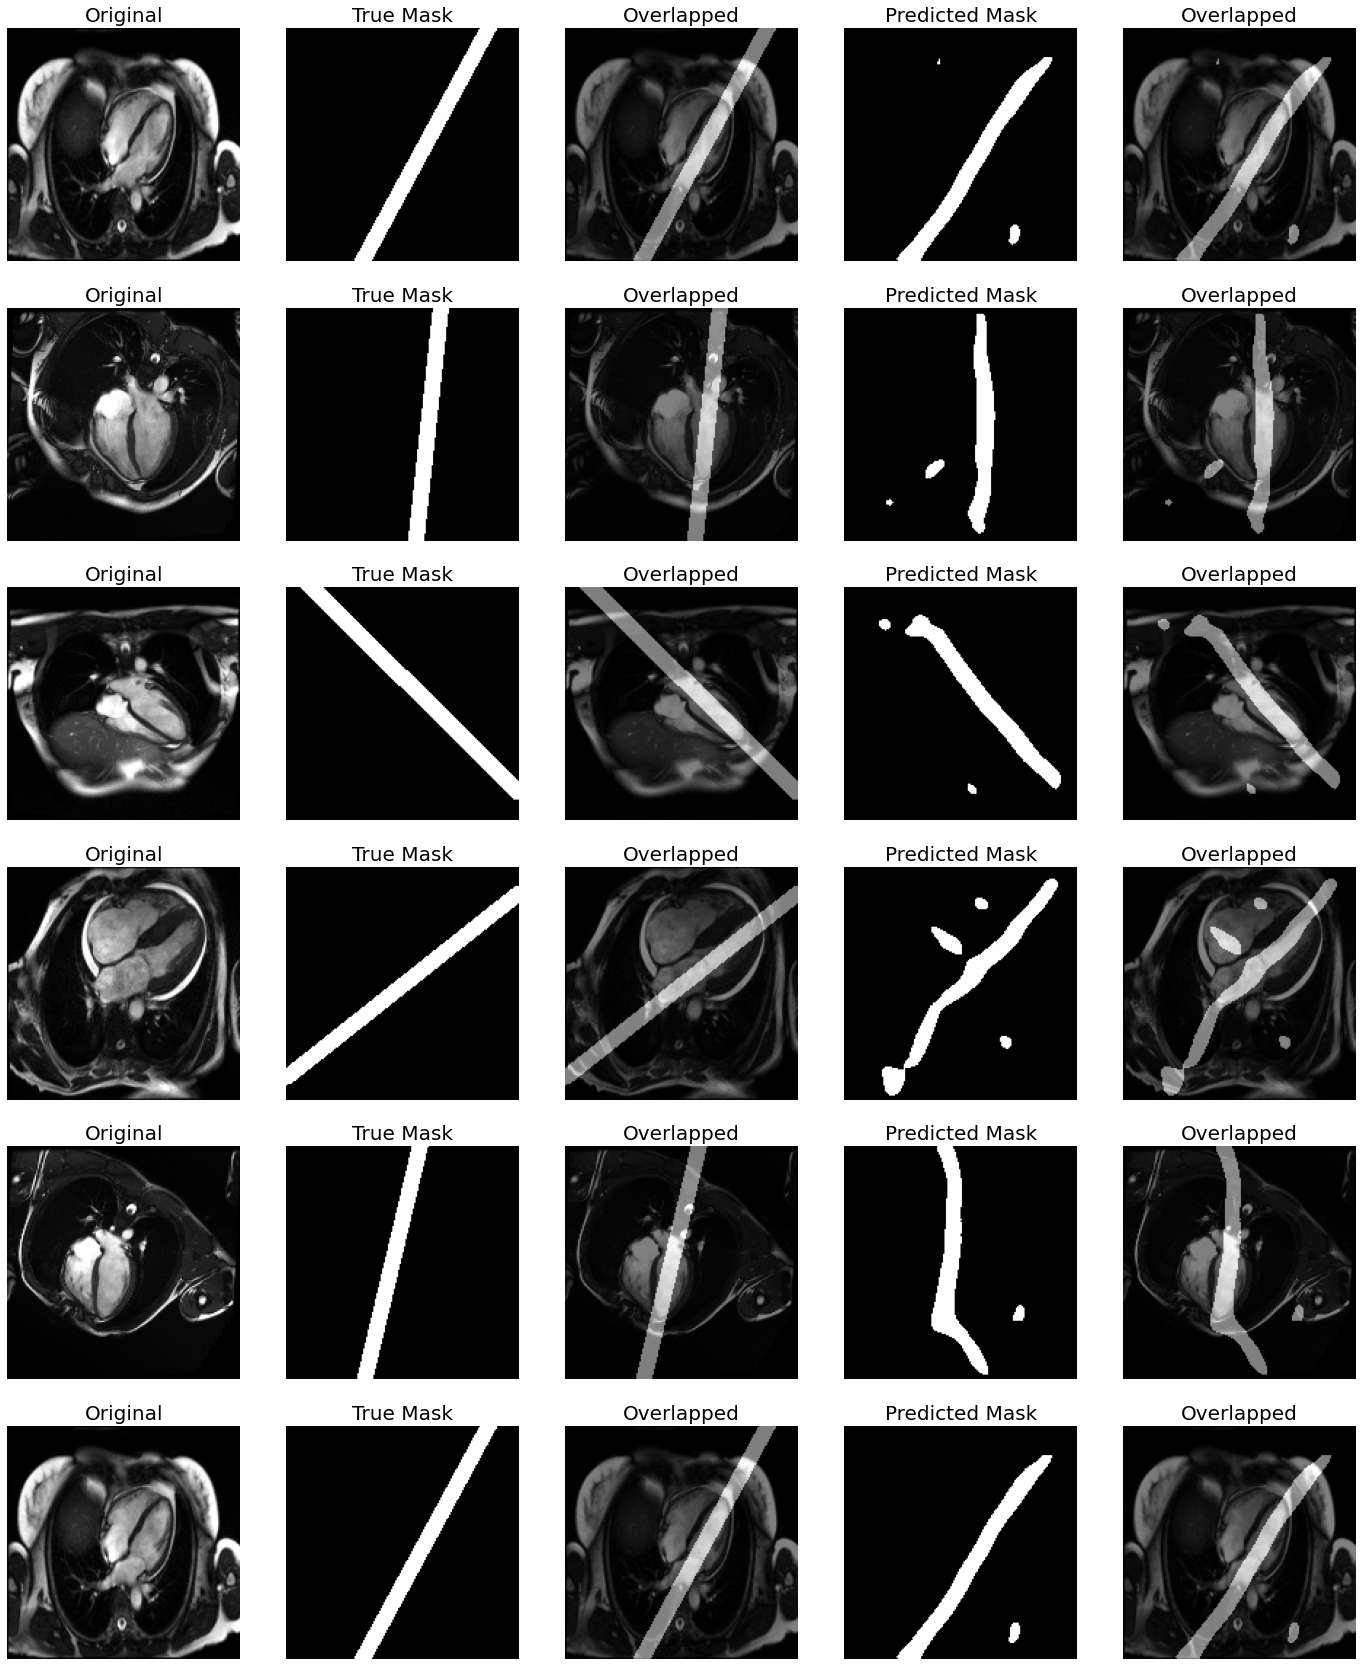

In [ ]:
test_images = val_images
test_masks = val_masks
test_cache = val_cache
N=6

fig = plt.figure(figsize=(25,30))

ind = [1, 2, 3, 4, 5]

for i in range(N):

  #PREDICT RESULTS
  img = test_images[i]
  true_msk = test_masks[i].squeeze()
  pred_msk = model.predict(np.expand_dims(img, 0))

  pred_msk[pred_msk > 0.5] = 1.0
  pred_msk[pred_msk < 0.5] = 0.0

  #PLOT RESULTS
  plt.subplot(N, 5, ind[0])
  plt.axis('off')
  plt.imshow(img.squeeze(), plt.cm.gray)
  plt.title('Original', {'fontsize': 20})

  plt.subplot(N, 5, ind[1])
  plt.axis('off')
  plt.imshow(true_msk, plt.cm.gray)
  plt.title('True Mask', {'fontsize': 20})

  plt.subplot(N, 5, ind[2])
  plt.axis('off')
  plt.imshow(img.squeeze(), plt.cm.gray)
  plt.imshow(true_msk, plt.cm.gray, alpha=0.5)
  plt.title('Overlapped', {'fontsize': 20}) 

  plt.subplot(N, 5, ind[3])
  plt.axis('off')
  plt.imshow(pred_msk.squeeze(), plt.cm.gray)
  plt.title('Predicted Mask', {'fontsize': 20}) 

  plt.subplot(N, 5, ind[4])
  plt.axis('off')
  plt.imshow(img.squeeze(), plt.cm.gray)
  plt.imshow(pred_msk.squeeze(), plt.cm.gray, alpha=0.5)
  plt.title('Overlapped', {'fontsize': 20})

  fig.subplots_adjust(wspace=0, hspace=0.2)

  ind = [x+5 for x in ind]

#plt.savefig(dest_path + 'predictions')

To numerically measure the amount of overlap between the true and predicted mask, the DICE score, which was described earlier, is used.

In [ ]:
def DICE(y_true, y_pred, smooth=1):

  #Calculate DICE score
  intersection = np.sum(y_true * y_pred)
  area_true = np.sum(y_true)
  area_pred = np.sum(y_pred)

  return (2 * intersection + smooth)/(area_true + area_pred + smooth)

In [ ]:
dice = []

for i in range(len(test_images)):
  img = test_images[i]
  true_msk = test_masks[i].squeeze()
  pred_msk = model.predict(np.expand_dims(img, 0)).squeeze()

  pred_msk[pred_msk > 0.5] = 1.0
  pred_msk[pred_msk < 0.5] = 0.0

  dice.append(DICE(true_msk, pred_msk))

In [ ]:
dice = np.array(dice)
print('Mean DICE score = ' + str(np.mean(dice)))

Mean DICE score = 0.5505780064195549


## 8.0 - Reconstruct Line from Mask

As could be seen from the above results, the UNet predicted masks are not of very good quality as they are not solid lines like in the true masks. However, the location and trajectory of the line on the image is quite similar to that of the true mask so they need not be discarded. Using this predicted mask as a primer, image processing and computer vision techniques could be used to reconstruct a solid line from the initial predicted line. This is performed using a reconstruction function which I wrote.

In [ ]:
#Import reconstructor function
from helper_functions import line_reconstructor

The reconstruction function will return a line parameterized by the slope and intercept. This is nice because now instead of using the DICE metric to measure overlap of masks, we can directly measure distance between both lines. To do this, we define a new metric called the root mean squared distance or RMSD. It's commonly used in bioinformatics for measuring distances between atoms in molecular structures, but we can use it in this task as well. Essentially the RMSD is calculated by selecting 200 points on both true and predicted lines and then calculating root mean squared distance between these points.

In [ ]:
def RMSD(A, B, C, points):
  x0, y0 = points
  distance = np.abs(A*x0 + B*y0 + C) /np.sqrt(A**2 + B**2)
  return np.sqrt(np.mean(distance**2))

The test images and the RMSD between the true and predicted lines are presented below.

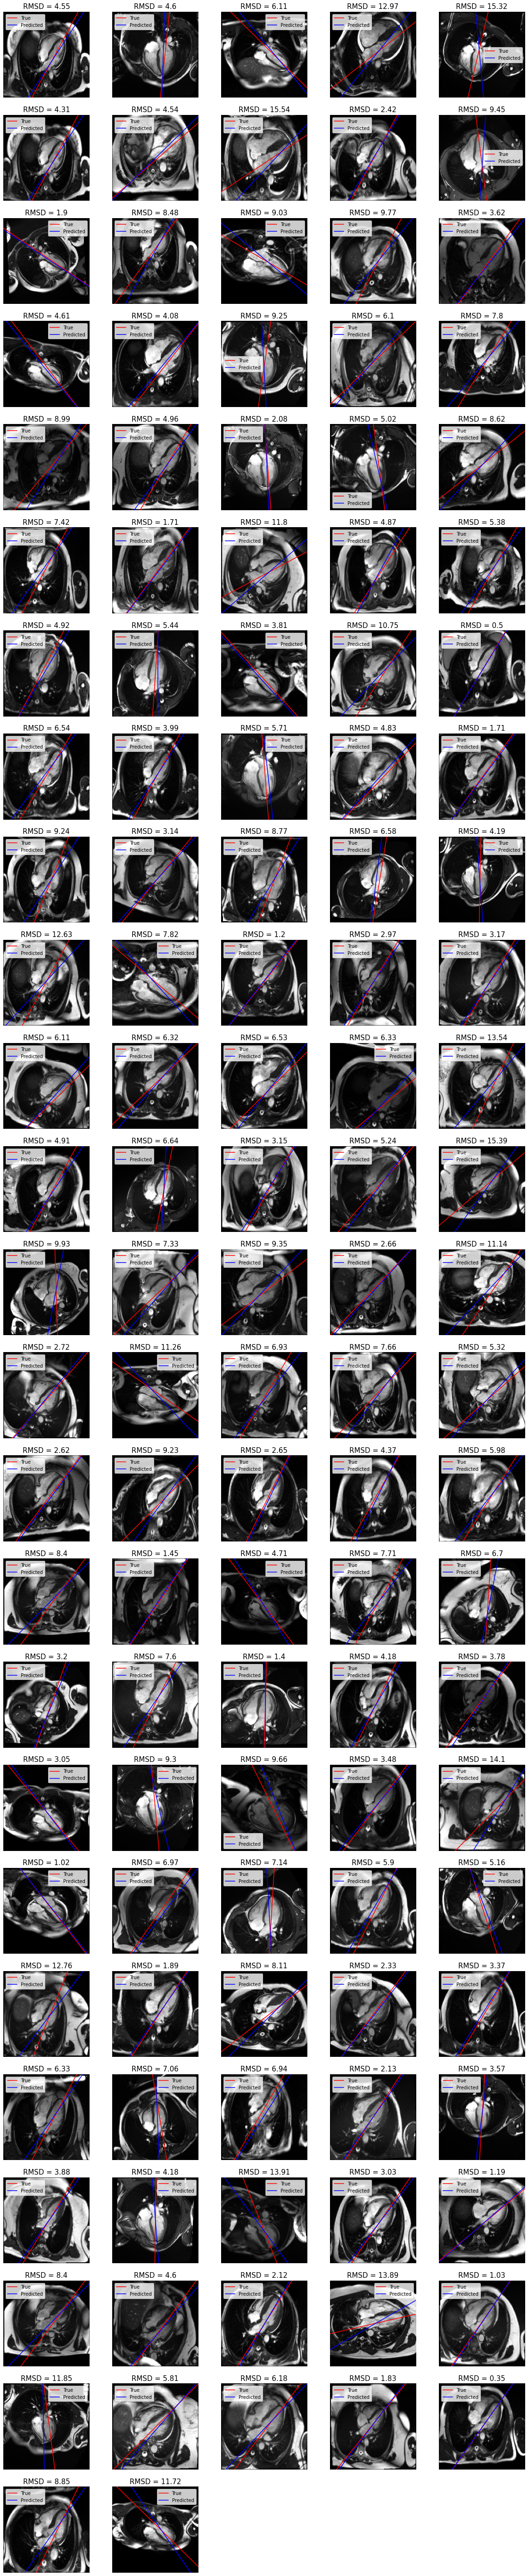

In [ ]:
#Predicted values will be appended here
m_pred = []
b_pred = []

#Error metrics
distances = []

#Plot results
plot_results = True
M=len(test_images)
N=5 

fig = plt.figure(figsize=(20, 100))

for k in range(M):
  #Extract true values
  test_x = test_images[k]
  test_y = test_masks[k]
  [m_true, b_true] = test_cache[k]

  #PREDICT THE LINE USING THE MODEL
  test_ypred = model.predict(np.expand_dims(test_x, 0))
  test_ypred = test_ypred.squeeze()
  test_x = test_x.squeeze()
  test_y = test_y.squeeze()

  #Convert to one-hot encoded mask
  test_ypred[test_ypred >= 0.5] = 1 
  test_ypred[test_ypred < 0.5] = 0

  #Reconstruct masks
  reconstructed_mask, params = line_reconstructor.line_reconstructor(test_ypred)
  m, b = params
  m_pred.append(m)
  b_pred.append(b)

  # ------- CALCULATE RMSD -------- #

  # Find the coordinates of boundary points of true line. Then space 200 points along the line.
  boundary_points = []
  p1 = (-b_true/m_true, 0)
  p2 = (0, b_true)
  p3 = (159, 159*m_true + b_true)
  p4 = ((159-b_true)/m_true, 159)

  for (i, j) in [p1, p2, p3, p4]:
    if 0 <= i <= 159 and 0 <= j <= 159:
      boundary_points.append((i, j))

  bp1, bp2 = boundary_points

  x = np.linspace(bp1[0], bp2[0], 200)
  y_true = m_true*x + b_true

  # For each of these 200 points, find the nearest point in line 2.
  A, B, C = m, -1, b
  rmsd = RMSD(A, B, C, (x, y_true))
  distances.append(rmsd)
  y_pred = m*x + b

  # ------ PLOT RESULTS ------ #

  if plot_results:
    plt.subplot(M//N + 1, N, k+1)
    plt.axis('off')
    plt.imshow(test_x, plt.cm.gray)
    x= np.arange(0, 160)
    y_true = m_true*x + b_true
    y_pred = m*x + b
    plt.plot(x, y_true, 'red')
    plt.plot(x, y_pred, 'blue')

    plt.xlim(0, test_x.shape[0] - 1)
    plt.ylim(test_x.shape[0] - 1, 0)
    plt.legend(['True', 'Predicted'])
    plt.title('RMSD = {}'.format(round(rmsd, 2)), {'fontsize': 15})

    #fig.subplots_adjust(hspace=0.2, wspace=0.2)

## 9.0 - Saving Results



The model weights and training history are saved using the code below.

In [ ]:
#Destination to save metrics
dest_path = 'model_1/V.16/'

#Saving weights to file
model.save_weights(dest_path + 'weights.h5')

#Saving the training history:
import pickle
with open(dest_path + 'trainHistoryDict', 'wb') as file_pi:
  pickle.dump(model.history.history, file_pi)

Using the code below, the RMSD metric values between the true and predicted lines are saved to an excel sheet.

In [ ]:
m_pred = np.array(m_pred).squeeze()
b_pred = np.array(b_pred).squeeze()

m_true = test_cache[:, 0]
b_true = test_cache[:, 1]

distances = np.array(distances)

#Create a final dataframe of the results
results = pd.DataFrame({'Distances':distances.squeeze()})
print(results.head(20))

#Compute Mean Euclidean Distance
print('\nMean Distance = ' + str(np.mean(distances)))

#results.to_excel(dest_path+'results.xlsx')

    Distances
0    4.552078
1    4.596629
2    6.114075
3   12.966414
4   15.320835
5    4.311063
6    4.544162
7   15.536313
8    2.421322
9    9.450861
10   1.901772
11   8.482883
12   9.033172
13   9.766181
14   3.618283
15   4.609366
16   4.076301
17   9.248281
18   6.102255
19   7.801374

Mean Distance = 6.219724586920734


The parameter estimation approach will be investigated in [part II](https://colab.research.google.com/drive/1XvIBFidtADbH6th5PHw_Ym6V0cfxBQHl?authuser=1#scrollTo=KtaUBjgCuCoq) of this notebook. 